In [16]:
# 🔹 Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
%matplotlib inline

# 🔹 Load Datasets
movies_df = pd.read_csv("C:/Users/arbaj/OneDrive/Documents/MovieAnalysis/movies_metadata.csv", low_memory=False)
ratings_df = pd.read_csv("C:/Users/arbaj/OneDrive/Documents/MovieAnalysis/ratings.csv")
links_df = pd.read_csv("C:/Users/arbaj/OneDrive/Documents/MovieAnalysis/links.csv")

# 🔹 Clean movies_df
movies_df = movies_df.dropna(subset=["title", "release_date"])
movies_df["budget"] = pd.to_numeric(movies_df["budget"], errors='coerce').fillna(0)
movies_df["revenue"] = pd.to_numeric(movies_df["revenue"], errors='coerce').fillna(0)
movies_df["release_date"] = pd.to_datetime(movies_df["release_date"], errors='coerce')

# 🔹 Parse genres column
def parse_genres(genres_str):
    if pd.isna(genres_str):
        return []
    try:
        genres_list = json.loads(genres_str.replace("'", "\""))
        return [genre['name'] for genre in genres_list]
    except Exception:
        return []

movies_df["genres_list"] = movies_df["genres"].apply(parse_genres)

# 🔹 Convert and merge IDs
movies_df = movies_df.rename(columns={"id": "tmdbId"})
movies_df["tmdbId"] = pd.to_numeric(movies_df["tmdbId"], errors='coerce')
links_df["tmdbId"] = pd.to_numeric(links_df["tmdbId"], errors='coerce')
links_df["movieId"] = pd.to_numeric(links_df["movieId"], errors='coerce')
ratings_df["movieId"] = pd.to_numeric(ratings_df["movieId"], errors='coerce')

# 🔹 Merge datasets
movies_with_links = pd.merge(movies_df, links_df, on='tmdbId', how='inner')

average_ratings = ratings_df.groupby('movieId')['rating'].agg(['mean', 'count']).reset_index()
average_ratings.columns = ['movieId', 'average_rating', 'number_of_ratings']

movies_with_ratings = pd.merge(movies_with_links, average_ratings, on='movieId', how='left')

# ✅ Preview final result
movies_with_ratings[['title', 'average_rating', 'number_of_ratings']].head()


,title,average_rating,number_of_ratings
0,Toy Story,3.888157,66008.0
1,Jumanji,3.236953,26060.0
2,Grumpier Old Men,3.175550,15497.0
3,Waiting to Exhale,2.875713,2981.0
4,Father of the Bride Part II,3.079565,15258.0


In [17]:
# Step: Merge with links on 'tmdbId'
movies_with_links = pd.merge(movies_df, links_df, on='tmdbId', how='inner')

# Step: Aggregate ratings
average_ratings = ratings_df.groupby('movieId')['rating'].agg(['mean', 'count']).reset_index()
average_ratings.columns = ['movieId', 'average_rating', 'number_of_ratings']

# Step: Merge with ratings
movies_with_ratings = pd.merge(movies_with_links, average_ratings, on='movieId', how='left')


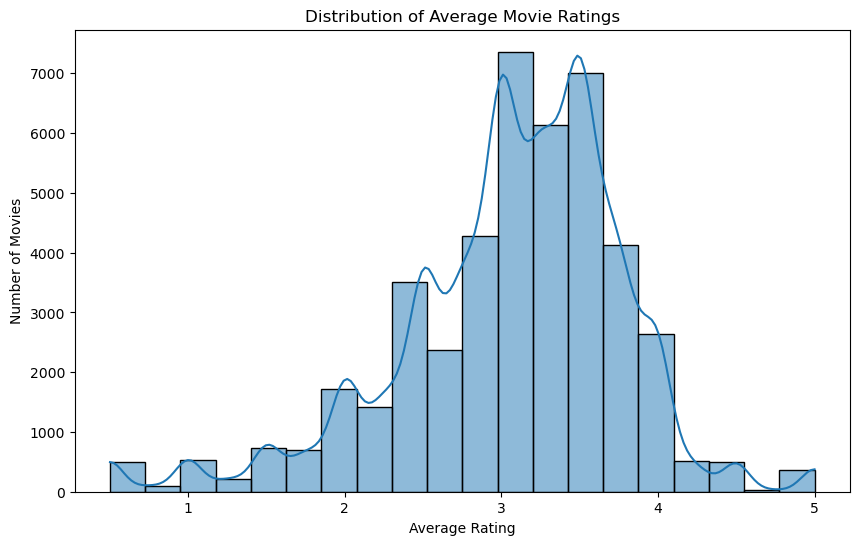

In [18]:
# Distribution of Average Ratings
plt.figure(figsize=(10, 6))
sns.histplot(movies_with_ratings['average_rating'].dropna(), bins=20, kde=True)
plt.title('Distribution of Average Movie Ratings')
plt.xlabel('Average Rating')
plt.ylabel('Number of Movies')
plt.show()


In [19]:
print(type(movies_with_ratings))
print(movies_with_ratings.shape)


<class 'pandas.core.frame.DataFrame'>
(45438, 29)


In [20]:
print(movies_with_ratings.columns.tolist())


['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'tmdbId', 'imdb_id', 'original_language', 'original_title', 'overview', 'popularity', 'poster_path', 'production_companies', 'production_countries', 'release_date', 'revenue', 'runtime', 'spoken_languages', 'status', 'tagline', 'title', 'video', 'vote_average', 'vote_count', 'genres_list', 'movieId', 'imdbId', 'average_rating', 'number_of_ratings']


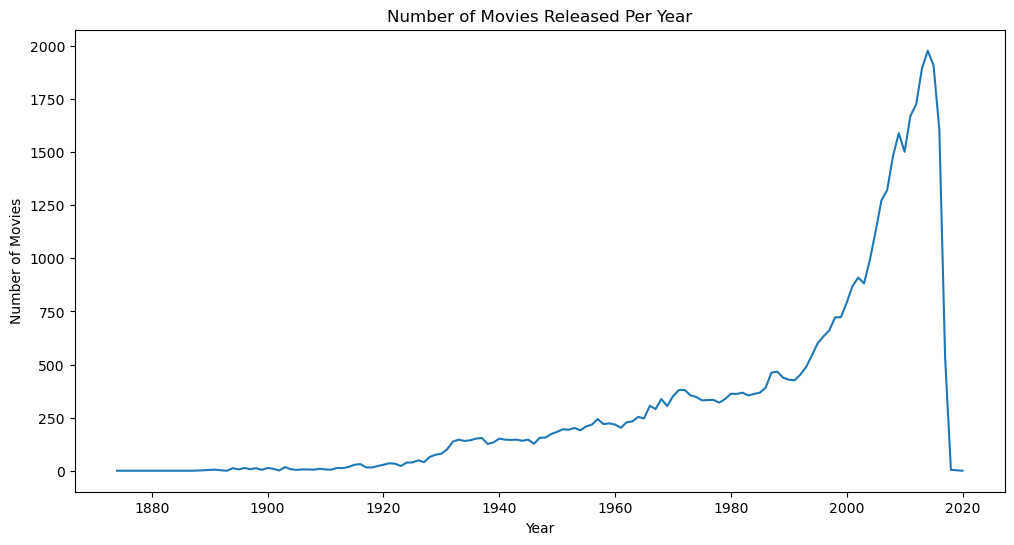

In [22]:
#movie released per year
movies_with_ratings['release_year'] = pd.to_datetime(movies_with_ratings['release_date'], errors='coerce').dt.year

plt.figure(figsize=(12, 6))
movies_with_ratings['release_year'].value_counts().sort_index().plot(kind='line')
plt.title('Number of Movies Released Per Year')
plt.xlabel('Year')
plt.ylabel('Number of Movies')
plt.show()


C:\Users\arbaj\AppData\Local\Temp\ipykernel_18316\2015227432.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  genre_ratings = genres_exploded.groupby('genres_list').apply(


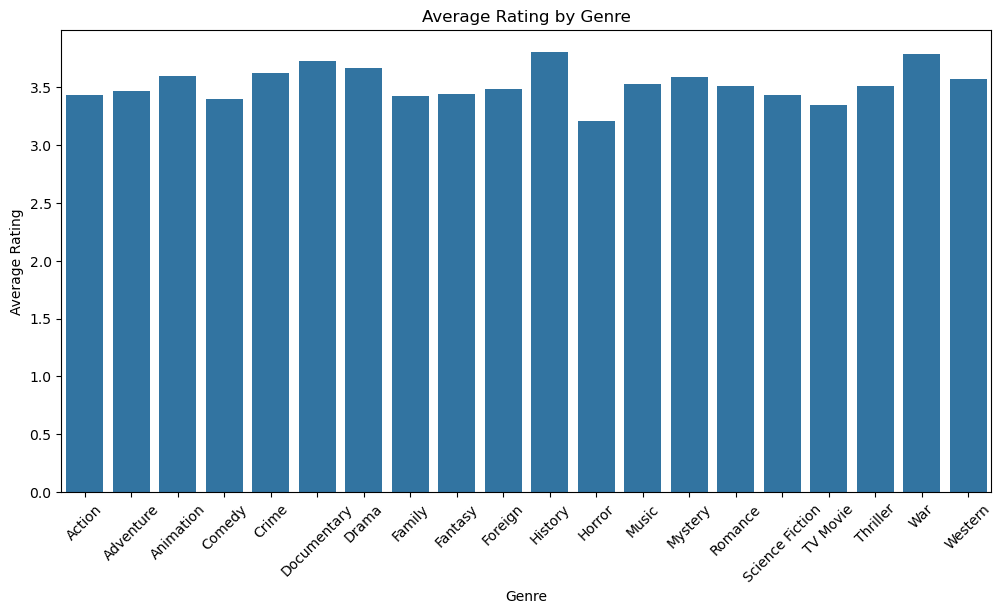

In [23]:
#average rating by genre
genres_exploded = movies_with_ratings.explode('genres_list')

genre_ratings = genres_exploded.groupby('genres_list').apply(
    lambda x: (x['average_rating'] * x['number_of_ratings']).sum() / x['number_of_ratings'].sum()
).reset_index()

genre_ratings.columns = ['genre', 'average_genre_rating']

plt.figure(figsize=(12, 6))
sns.barplot(x='genre', y='average_genre_rating', data=genre_ratings)
plt.title('Average Rating by Genre')
plt.xticks(rotation=45)
plt.ylabel('Average Rating')
plt.xlabel('Genre')
plt.show()


In [28]:
# Group only the necessary columns
genre_ratings = genres_exploded.groupby('genres_list')[['average_rating', 'number_of_ratings']].apply(
    lambda x: (x['average_rating'] * x['number_of_ratings']).sum() / x['number_of_ratings'].sum()
).reset_index(name='average_genre_rating')


In [29]:
print(genre_ratings.head())


  genres_list  average_genre_rating
0      Action              3.436931
1   Adventure              3.465711
2   Animation              3.600553
3      Comedy              3.399248
4       Crime              3.624919


C:\Users\arbaj\AppData\Local\Temp\ipykernel_18316\1312422236.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='average_rating', y='title', data=top_movies, palette='viridis')


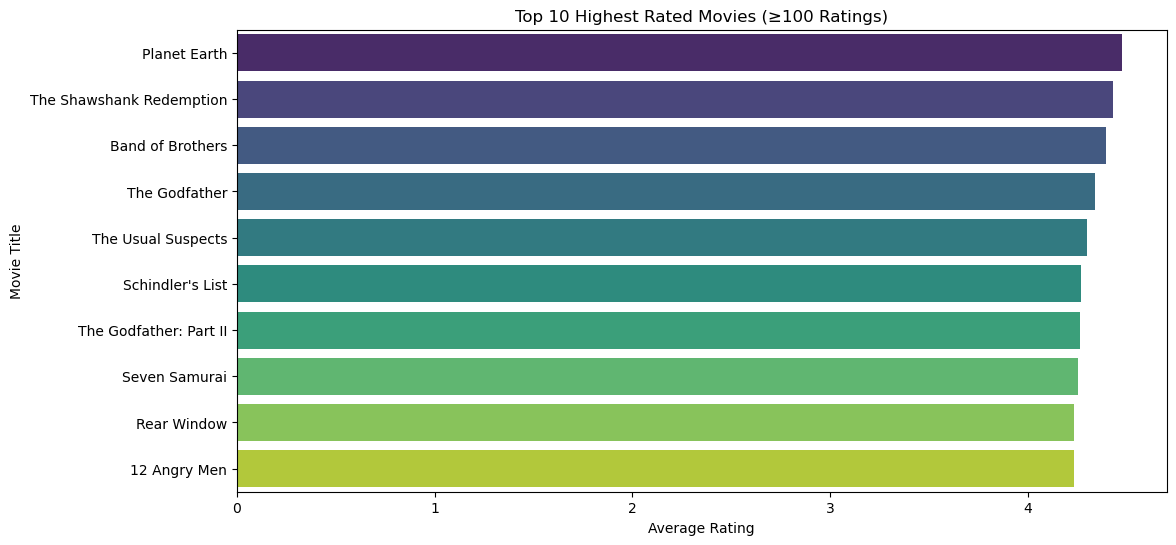

In [30]:
#Top 10 Highest Rated Movies (with at least 100 votes)
top_movies = movies_with_ratings[movies_with_ratings['number_of_ratings'] >= 100]
top_movies = top_movies.sort_values(by='average_rating', ascending=False).head(10)

plt.figure(figsize=(12,6))
sns.barplot(x='average_rating', y='title', data=top_movies, palette='viridis')
plt.title('Top 10 Highest Rated Movies (≥100 Ratings)')
plt.xlabel('Average Rating')
plt.ylabel('Movie Title')
plt.show()


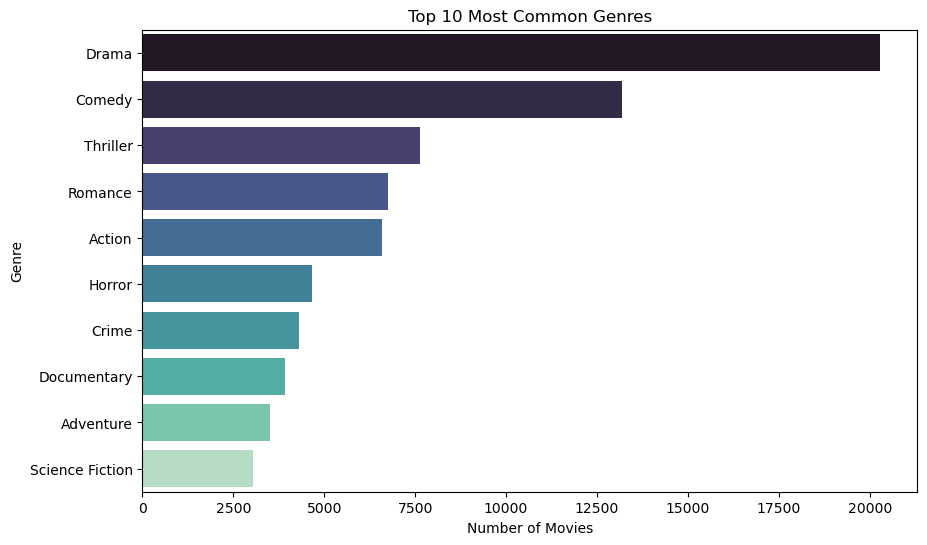

In [34]:
#Most Popular Genres by Number of Movies
plt.figure(figsize=(10,6))
sns.barplot(
    x=genre_counts.values,
    y=genre_counts.index,
    hue=genre_counts.index,
    palette='mako',
    legend=False
)
plt.title('Top 10 Most Common Genres')
plt.xlabel('Number of Movies')
plt.ylabel('Genre')
plt.show()


C:\Users\arbaj\AppData\Local\Temp\ipykernel_18316\1341277034.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_runtime.index, y=genre_runtime.values, palette='coolwarm')


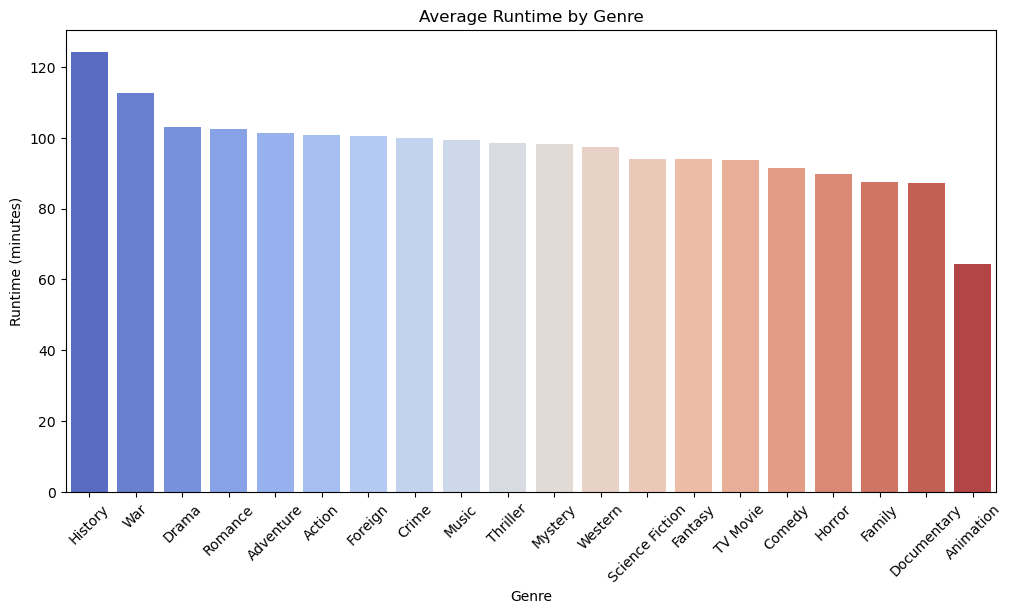

In [35]:
# Average Runtime per Genre
genre_runtime = movies_with_ratings.explode('genres_list').groupby('genres_list')['runtime'].mean().sort_values(ascending=False).dropna()

plt.figure(figsize=(12,6))
sns.barplot(x=genre_runtime.index, y=genre_runtime.values, palette='coolwarm')
plt.title('Average Runtime by Genre')
plt.ylabel('Runtime (minutes)')
plt.xlabel('Genre')
plt.xticks(rotation=45)
plt.show()


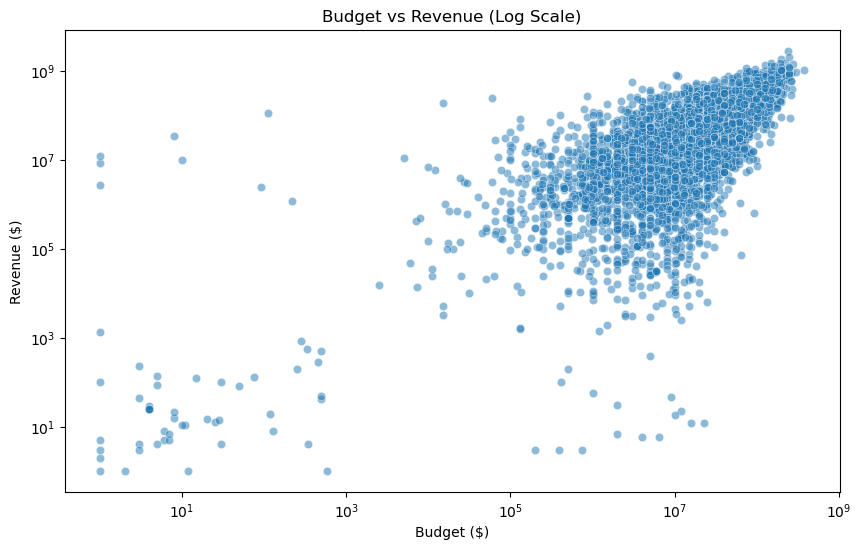

In [36]:
# Budget vs Revenue Scatter Plot (with Log Scale)

plt.figure(figsize=(10,6))
sns.scatterplot(data=movies_with_ratings, x='budget', y='revenue', alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.title('Budget vs Revenue (Log Scale)')
plt.xlabel('Budget ($)')
plt.ylabel('Revenue ($)')
plt.show()


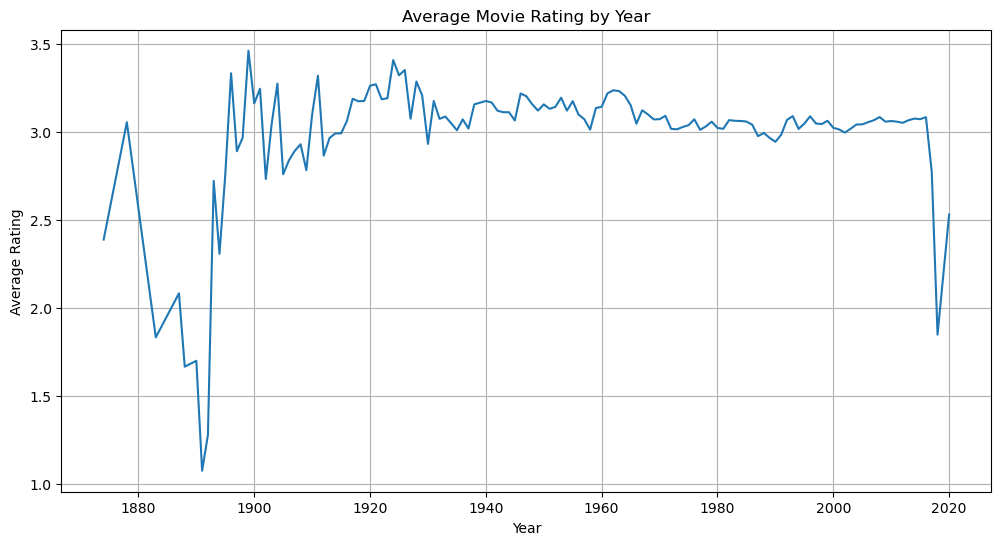

In [37]:
#Rating Trends Over Time
yearly_avg = movies_with_ratings.groupby('release_year')['average_rating'].mean()

plt.figure(figsize=(12,6))
yearly_avg.plot()
plt.title('Average Movie Rating by Year')
plt.xlabel('Year')
plt.ylabel('Average Rating')
plt.grid(True)
plt.show()


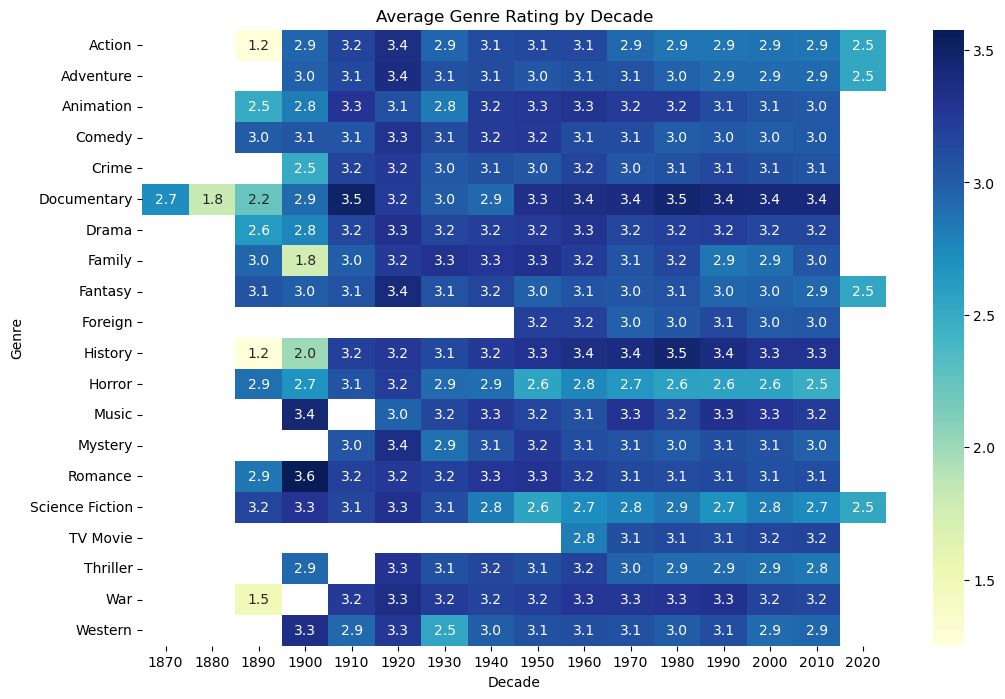

In [38]:
# Heatmap of Ratings by Decade and Genre
# Add decade column
movies_with_ratings['decade'] = (movies_with_ratings['release_year'] // 10) * 10

# Explode genres and group
genre_decade = movies_with_ratings.explode('genres_list')
heatmap_data = genre_decade.pivot_table(
    index='genres_list',
    columns='decade',
    values='average_rating',
    aggfunc='mean'
)

plt.figure(figsize=(12,8))
sns.heatmap(heatmap_data, cmap='YlGnBu', annot=True, fmt=".1f")
plt.title('Average Genre Rating by Decade')
plt.ylabel('Genre')
plt.xlabel('Decade')
plt.show()


In [40]:
# ✅ Step 0: Imports
import sqlite3
import pandas as pd

# ✅ Step 1: Convert list columns to strings (e.g. genres_list)
if 'genres_list' in movies_with_ratings.columns:
    movies_with_ratings['genres_list'] = movies_with_ratings['genres_list'].apply(
        lambda x: ', '.join(x) if isinstance(x, list) else ''
    )

# ✅ Step 2: Connect to SQLite database (creates movies.db in your working directory)
conn = sqlite3.connect('movies.db')

# ✅ Step 3: Save DataFrame to SQL table
movies_with_ratings.to_sql('movies', conn, if_exists='replace', index=False)

# ✅ Step 4: Write and execute an SQL query — Highest-rated movie with ≥ 1000 ratings
query = """
SELECT title, average_rating, number_of_ratings
FROM movies
WHERE number_of_ratings >= 1000
ORDER BY average_rating DESC
LIMIT 1;
"""

# ✅ Step 5: Execute query and show result
result = pd.read_sql_query(query, conn)

# ✅ Step 6: Display result
print("🎬 Highest-rated movie (≥ 1000 ratings):")
print(result)

# ✅ Step 7: Close the database connection
conn.close()


🎬 Highest-rated movie (≥ 1000 ratings):
                      title  average_rating  number_of_ratings
0  The Shawshank Redemption        4.429015            91082.0


In [ ]:
## Step 9: Insights

### ⭐ 1. Rating Trends
- Most movies have average ratings between **3.0 and 3.5**.
- Very few movies exceed **8.0** average rating with a high number of votes.
- The distribution is close to normal.

### 🎬 2. Movie Production Over Time
- Film production has increased steadily, especially after 2000.
- Recent years see higher output due to digital distribution and streaming.

### 🎭 3. Genre Observations
- **Drama**, **History**, and **Documentary** genres often score higher on average.
- **Action** and **Comedy** are the most common, but not always highest-rated.


In [43]:
# Save the final cleaned dataset to CSV
movies_with_ratings.to_csv('cleaned_movie_data.csv', index=False)
print("✅ Cleaned movie data saved as 'cleaned_movie_data.csv'")


✅ Cleaned movie data saved as 'cleaned_movie_data.csv'


In [ ]:
## Step 10: Conclusion
- Datasets merged and cleaned: ✅
- Ratings and genres analyzed: ✅
- SQL queries executed: ✅
- Visual insights created: ✅
